# Volume 4: Heat Flow
    <Name> Dallin Stewart
    <Class> ACME 002
    <Date>  “Life breaks us. Then we fill the cracks with something stronger.”

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import matplotlib.animation as animation
from scipy.sparse import diags
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [2]:
%matplotlib inline

In [21]:
def ode_solver(x, t, nu, f):
    """
    Parameters:
        x: (numpy array) position vector
        t: (numpy array) time vector
        nu: (float) constant
        f: (function) function to solve with
    """
    # initialize parameters for solution matrix
    lam = nu * (t[1] - t[0]) / (x[1] - x[0])**2
    sub_t = len(t)
    sub_x = len(x)

    # initialize diagonal vectors
    diag1 = np.ones(sub_x) * (1 - 2 * lam)
    diag1[0] = 1
    diag1[-1] = 1
    diag2 = np.ones(sub_x - 1) * lam
    diag2[0] = 0
    diag3 = np.ones(sub_x - 1) * lam
    diag3[-1] = 0

    # initialize solution matrix and U
    A = np.diag(diag1) + np.diag(diag2, k=1) + np.diag(diag3, k=-1)

    # solve for U
    U = f(x)
    U = np.vstack([U, A@U])
    for _ in range(1, sub_t):
        U = np.vstack([U, A@U[-1]])
    
    return U

In [28]:
def animate(x, u, title):
    # initialize figure
    fig = plt.figure()
    plt.ioff()
    ax = fig.add_subplot(111)

    # set plot parameters
    ax.set_xlim([x[0], x[-1]])
    ax.set_ylim((min(min(r) for r in u), max(max(r) for r in u)))
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title(title)

    # initialize line
    line, = ax.plot([], [], lw=2)
    def update(i):
        line.set_data(x, u[i])
        return line,

    plt.ioff()
    ani = animation.FuncAnimation(fig, update, frames=range(u.shape[0]), interval=25, repeat=True)
    ani.save(f'/mnt/c/users/dalli/source/acme_senior/vl4labs/HeatFlow/{title}.mp4')

# Problem 1

Consider the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = 0.05 u_{xx}, \quad x \in [0,1], \quad t \in [0,1]\\
	&{ } u(0,t) = 0,\quad u(1,t) = 0,\\
	&{ } u(x,0) = 2\max\{0.2 - |x-0.5|,0\}.
	\end{split}
\end{align}

Approximate the solution $u(x,t)$ by taking 6 subintervals in the $x$ dimension and 10 subintervals in time.
Plot the approximation at $t=0, t=0.4$, and $t=1$.

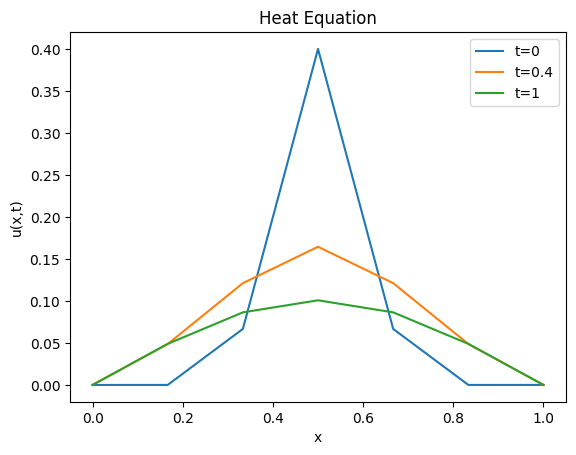

In [23]:
x = np.linspace(0, 1, 7)
t = np.linspace(0, 1, 11)
_nu = 0.05
_f = lambda x: 2*np.where(0.2 - np.abs(x-0.5) > 0, 0.2 - np.abs(x-0.5), 0)

U = ode_solver(x, t, _nu, _f)

plt.plot(x, U[0], label='t=0')
plt.plot(x, U[4], label='t=0.4')
plt.plot(x, U[-1], label='t=1')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Heat Equation')
plt.legend()
plt.show()

# Problem 2

Solve the initial/boundary value problem

\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1], \\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}
	\end{split}
\end{align}

using the first order explicit method (1.1).
Use 140 subintervals in the $x$ dimension and 70 subintervals in time.
The initial and final states are shown in Figures 1 and 2.
Animate your results.

Explicit methods usually have a stability condition, called a CFL condition (for Courant-Friedrichs-Lewy).
For method (1.1) the CFL condition that must be satisfied is that:

$$\lambda \leq \frac{1}{2}$$

Repeat your computations using 140 subintervals in the $x$ dimension and 66 subintervals in time. Animate the results.
For these values the CFL condition is broken; you should easily see the result of this instability in the approximation $U^{66}$.


In [31]:
x = np.linspace(-12, 12, 141)
t = np.linspace(0, 1, 71)
_nu = 1
_f = lambda x: np.where(1 - x**2 > 0, 1 - x**2, 0)

U = ode_solver(x, t, _nu, _f)

animate(x, U, 'heat_equation1')

<video src="heat_equation1-1.mp4" controls title="Title"></video>

In [33]:
x = np.linspace(-12, 12, 141)
t = np.linspace(0, 1, 67)
_nu = 1
_f = lambda x: np.where(1 - x**2 > 0, 1 - x**2, 0)

U = ode_solver(x, t, _nu, _f)

animate(x, U, 'heat_equation2')


<video src="heat_equation2.mp4" controls>

# Problem 3

Using the Crank Nicolson method, numerically approximate the solution $u(x,t)$ of the problem
\begin{align}
	\begin{split}
	&{ } u_t = u_{xx}, \quad x \in [-12,12],\quad t \in [0,1],\\
	&{ } u(-12,t) = 0,\quad u(12,t) = 0,\\
	&{ } u(x,0) = \max\{1 - x^2,0\}.
	\end{split}
\end{align}
Note that this is an implicit linear scheme; hence, the most efficient way to find $U^{j+1}$ is to create the matrix $B$ as a sparse matrix and then use \li{scipy.sparse.linalg.solve}.

Demonstrate that the numerical approximation at $t = 1$ converges.
Do this by computing $U$ at $t=1$ using $20,40,80,160,320$, and $640$ steps.
Use the same number of steps in both time and space.
Reproduce the loglog plot shown in the lab.
The slope of the line there shows the order of convergence.

To measure the error, use the solution with the smallest $h$ (largest number of intervals) as if it were the exact solution, then sample each solution only at the x-values that are represented in the solution with the largest $h$ (smallest number of intervals).
Use the $\infty$-norm on the arrays of values at those points to measure the error.

Notice that, since the Crank-Nicolson method is unconditionally stable, there is no CFL condition, and we can safely use the same number of intervals in time and space.

In [35]:
def heat_cn(a, b, alpha, beta, f, nu, T, nx, nt):
    """Computes the Crank-Nicholson solution to the heat equation initial/boundary
    value problem:
    
        u_t = νu_xx, x∈[x0,x1] t∈[t0,t1]
        u(x0,t) = 0, u(x1,t) = 0
        u(x,0) = f(x)
        
        Parameters:
            a - left x boundary (float)
            b - right x boundary (float)
            alpha - left BC (float)
            beta - right BC (float)
            f - initial position (function)
            nu - heat diffusion coefficient (float)
            T - final time (float)
            nx - number of x steps (int)
            nt - number of time steps (int)
            
        Returns:
            U - approximate solution (ndarray(nt,nx))
            x - position array (ndarray(nx,))
    """
    # initialize grid
    x = np.linspace(a, b, nx+1)
    t = np.linspace(0, T, nt+1)

    # initialize parameters for solution matrix
    lam = nu * (t[1] - t[0]) / (2*(x[1] - x[0]))**2
    sub_t = len(t)
    sub_x = len(x)

    # initialize diagonal vectors
    diag0 = np.ones(sub_x) * (1 + 2 * lam)
    diag0[0] = 1
    diag0[-1] = 1
    diag1 = np.ones(sub_x) * (1 - 2 * lam)
    diag1[0] = 1
    diag1[-1] = 1
    diag2 = np.ones(sub_x - 1) * lam
    diag2[0] = 0
    diag3 = np.ones(sub_x - 1) * lam
    diag3[-1] = 0

    # initialize A and B matrices
    A = np.diag(diag1) + np.diag(diag2, k=1) + np.diag(diag3, k=-1)
    B = np.diag(diag0) - np.diag(diag2, k=1) - np.diag(diag3, k=-1)
    A = sparse.csr_matrix(A)
    B = sparse.csr_matrix(B)

    # compute U
    U = f(x)
    U = np.vstack([U, spsolve(B, A@U)])
    for _ in range(sub_t-2):
        U = np.vstack([U, spsolve(B, A@U[-1])])
    
    return U, x

In [54]:
# initialize parameters for heat flow
_nu = 1
_f = lambda x: np.where(1 - x**2 > 0, 1 - x**2, 0)
a = -12
b = 12
alpha = 0
beta = 0
T = 1

# define step counts
steps = [20, 40, 80, 160, 320, 640]

# initialize list variables
us = []
errs = []
h_list = [(b - a) / step for step in steps][:-1][::-1]

# compute solutions
for i, step in enumerate(steps[::-1]):
    u, x = heat_cn(a, b, alpha, beta, _f, _nu, T, step, step)
    if i > 0:        
        errs.append(max(np.abs(us[0][-1][::640//step] - u[-1])))
    us.append(u)

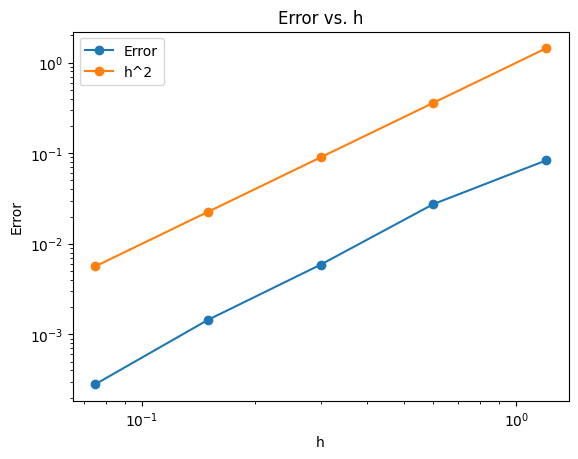

In [58]:
#plotting stuff
plt.loglog(h_list, errs, "-o", label="Error")
plt.loglog(h_list, [h**2 for h in h_list], "-o", label="h^2")
plt.title('Error vs. h')
plt.xlabel('h')
plt.ylabel('Error')
plt.legend()
plt.show()